# Lending Club Final Model

By: Kevin Kuc

## Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import csv
import copy

# data preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from numpy.random.mtrand import binomial

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image
from matplotlib.ticker import PercentFormatter

# model fit
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from keras import metrics
from tensorflow.keras import initializers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# For producing decision tree diagrams.
from IPython.display import Image

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'


## Step 2: Read data

In [2]:
# Training
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
validation_df = pd.read_csv('../data/val_data.csv')

train_df_deep = copy.deepcopy(train_df)
test_df_deep = copy.deepcopy(test_df)
validation_df_deep = copy.deepcopy(validation_df)

# Drop nan values
train_df_deep.dropna(axis=0, inplace=True)
test_df_deep.dropna(axis=0, inplace=True)
validation_df_deep.dropna(axis=0, inplace=True)

In [3]:
#Find Shape
print("Shape of training:", train_df_deep.shape)
print("Shape of test:", test_df_deep.shape)
print("Shape of validation:", validation_df_deep.shape)

Shape of training: (191993, 34)
Shape of test: (59999, 34)
Shape of validation: (47999, 34)


## Feature Selection
### full_features, partial_features, selected_features

In [4]:
features_target = train_df_deep.columns
full_features = features_target.drop(['loan_status'])
partial_features = full_features.drop(['recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'tax_liens', 'disbursement_method',
       'debt_settlement_flag'])
partial_features

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee'],
      dtype='object')

In [5]:
X_train_feat = train_df_deep[full_features].astype(float).values
y_train_feat = train_df_deep['loan_status'].astype(float).values

# Use SelectKBest to select the top k features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=10)  # Adjust k as needed

# Fit and get the selector to your training data
selector.fit(X_train_feat, y_train_feat)
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = [full_features[i] for i in selected_indices]

print("Selected Features:", selected_features)

Selected Features: ['int_rate', 'sub_grade', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'debt_settlement_flag']


In [6]:
X_train_shape = train_df_deep[full_features].astype(float).values.shape
y_train_shape = train_df_deep['loan_status'].astype(float).values.shape

X_val_shape = validation_df_deep[full_features].astype(float).values.shape
y_val_shape = validation_df_deep['loan_status'].astype(float).values.shape

X_test_shape = test_df_deep[full_features].astype(float).values.shape
y_test_shape = test_df_deep['loan_status'].astype(float).values.shape

In [7]:
print(f'X_train = {X_train_shape}, Y_train = {y_train_shape}')
print(f'X_val = {X_val_shape}, Y_val = {y_val_shape}')
print(f'X_val = {X_test_shape}, Y_val = {y_test_shape}')

X_train = (191993, 33), Y_train = (191993,)
X_val = (47999, 33), Y_val = (47999,)
X_val = (59999, 33), Y_val = (59999,)


## Step 3: Model Build

All features

In [8]:
def build_model(features,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01):
    """Build a binary logistic regression model using Keras.

    Args:
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Create sequential keras model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    # implement hidden layers if specified
    if hidden_layer_sizes != []:
        for layer in hidden_layer_sizes:
            model.add(tf.keras.layers.Dense(units=layer,
                                 activation=activation))

    # final layer
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    if isinstance(optimizer, str):
        opt_class = getattr(tf.keras.optimizers, optimizer)
        optimizer = opt_class(learning_rate=learning_rate)


    # compile the model with the specified optimizer
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    return model

def train_and_evaluate_nn(features,
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5,
                       batch_size=128
                       ):

    # Build the model.
    model = build_model(features = features,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

    # Select the dataset.
    X_train = train_df_deep[features].astype(float).values
    y_train = train_df_deep['loan_status'].astype(float).values

    X_val = validation_df_deep[features].astype(float).values
    y_val = validation_df_deep['loan_status'].astype(float).values

    # Train the model.
    print('Training...')
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        shuffle=True
                        )

    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy',color='#003262')
    plt.plot(val_accuracy, label='validation accuracy',color='#FDB515')
    plt.xticks(np.linspace(0,num_epochs,10)//1)
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print(pd.DataFrame.from_dict({'train_accuracy':[train_accuracy[-1]], 'val_accuracy':[val_accuracy[-1]]}))

    print(model.summary())

    return model

Training...
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - accuracy: 0.9265 - loss: 582.9853 - val_accuracy: 0.9766 - val_loss: 5.2926
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - accuracy: 0.9917 - loss: 5.3549 - val_accuracy: 0.9979 - val_loss: 2.3850
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step - accuracy: 0.9943 - loss: 3.5885 - val_accuracy: 0.9899 - val_loss: 12.3985
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - accuracy: 0.9916 - loss: 8.4589 - val_accuracy: 0.9976 - val_loss: 4.2056
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step - accuracy: 0.9933 - loss: 6.7200 - val_accuracy: 0.9911 - val_loss: 10.6687
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - accuracy: 0.9940 - loss: 5.5388 - val_accuracy: 0.9911 - val_loss: 1.5551
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - accuracy: 0.9942 - loss: 5.3808 - val_accuracy: 0.9951 - val_loss: 11.2009
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - a

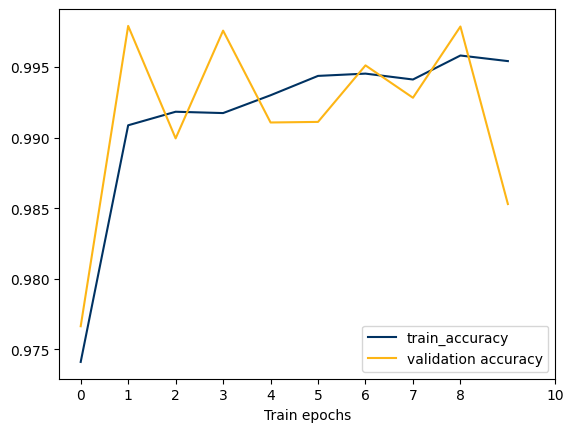

   train_accuracy  val_accuracy
0            1.00          0.99


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104 (420.00 B)

 Trainable params: 34 (136.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70 (284.00 B)

None
Validation Accuracy with relu & Adam: <Sequential name=sequential, built=True>


In [9]:
model_full_features = train_and_evaluate_nn(full_features,
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10)
print('Validation Accuracy with relu & Adam:', model_full_features)


Training...
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.9154 - loss: 300.7839 - val_accuracy: 0.9949 - val_loss: 2.5041
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - accuracy: 0.9895 - loss: 6.4172 - val_accuracy: 0.9937 - val_loss: 3.1018
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.9918 - loss: 4.5810 - val_accuracy: 0.9961 - val_loss: 2.2275
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - accuracy: 0.9911 - loss: 7.1760 - val_accuracy: 0.9944 - val_loss: 5.8018
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - accuracy: 0.9941 - loss: 5.4935 - val_accuracy: 0.9962 - val_loss: 2.4989
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - accuracy: 0.9921 - loss: 5.5564 - val_accuracy: 0.9864 - val_loss: 6.4277
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - accuracy: 0.9921 - loss: 7.6830 - val_accuracy: 0.9956 - val_loss: 5.7818
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - accu

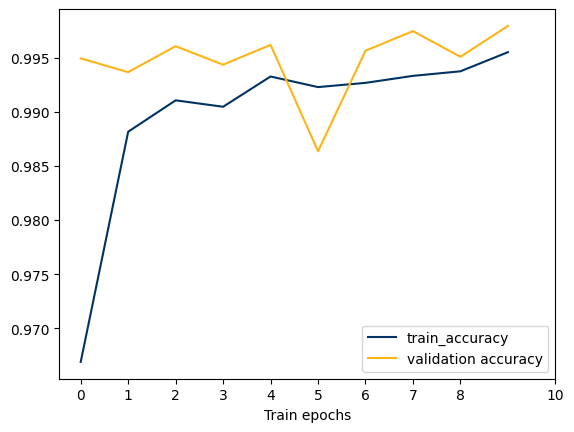

   train_accuracy  val_accuracy
0            1.00          1.00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (300.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50 (204.00 B)

None
Validation Accuracy with relu & Adam: <Sequential name=sequential, built=True>


In [10]:
model_partial_features = train_and_evaluate_nn(partial_features,
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10)
print('Validation Accuracy with relu & Adam:', model_partial_features)


Training...
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - accuracy: 0.8250 - loss: 157.7873 - val_accuracy: 0.9312 - val_loss: 3.8062
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - accuracy: 0.9204 - loss: 4.0176 - val_accuracy: 0.9367 - val_loss: 3.1818
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step - accuracy: 0.9198 - loss: 4.2866 - val_accuracy: 0.9291 - val_loss: 3.6586
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.9215 - loss: 4.0164 - val_accuracy: 0.9255 - val_loss: 3.7436
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step - accuracy: 0.9231 - loss: 4.2211 - val_accuracy: 0.9402 - val_loss: 2.1936
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - accuracy: 0.9234 - loss: 3.5971 - val_accuracy: 0.9257 - val_loss: 3.1188
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - accuracy: 0.9263 - loss: 3.5075 - val_accuracy: 0.9441 - val_loss: 2.1209
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accu

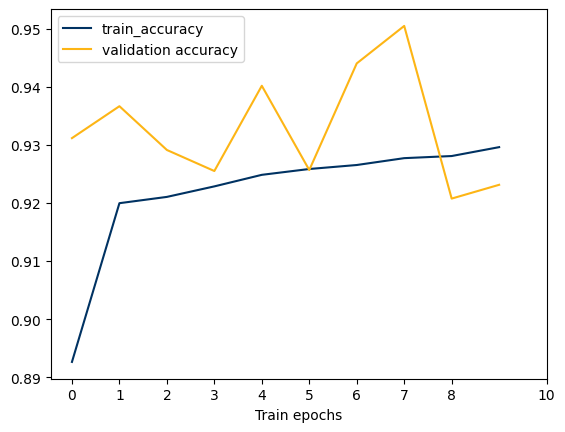

   train_accuracy  val_accuracy
0            0.93          0.92


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (144.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24 (100.00 B)

None
Validation Accuracy with relu & Adam: <Sequential name=sequential, built=True>


In [11]:
model_selected_features = train_and_evaluate_nn(selected_features,
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10)
print('Validation Accuracy with relu & Adam:', model_selected_features)

In [14]:
!pip list


zsh:1: /Users/kevinkuc/Documents/personal_projects/lending_club_machine_learning/.venv/bin/pip: bad interpreter: /Users/kevinkuc/Documents/personal_projects/lending_club_ml/.venv/bin/python: no such file or directory
/opt/homebrew/Cellar/pyenv/2.3.35/pyenv.d/exec/pip-rehash/pip: /Users/kevinkuc/Documents/personal_projects/lending_club_machine_learning/.venv/bin/pip: /Users/kevinkuc/Documents/personal_projects/lending_club_ml/.venv/bin/python: bad interpreter: No such file or directory
